First, we install the required libraries and import the necessary functions. 

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 17.6MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 1.1MB 55.5MB/s 
     |████████████████████████████████| 194kB 57.3MB/s 
     |████████████████████████████████| 61kB 11.3MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

# Creating the model

This model will basically be a copy of the model from the first chapter, but we'll give it a GUI (general user inferface).

In [10]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=41,
    label_func=is_cat, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.166722,0.030570,0.012855,00:49


epoch,train_loss,valid_loss,error_rate,time
0,0.062521,0.010038,0.002706,00:54


The above code trains a model to be able to recognize a cat in an image.

1. `from fastai.vision.all import *` imports the needed functions from `fastai.vision.all`.
2. `path = untar_data(URLs.PETS)/'images'` downloads a labelled dataset from the fast.ai datasets collection and extracts the file. 
3. `dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=lambda x: x[0].isupper(), item_tfms=Resize(224))` creates an `ImageDataLoaders`. `.from_name_func` means that we're getting the labels from the file's name. 
4. `learn = cnn_learner(dls, resnet34, metrics=error_rate)` creates a CNN (convolutional neural network) with the architecture `resnet34` (a neural network with 34 layers), the data (`dls`), and the `error_rate` metric. 
5. `learn.fine_tune(1)` trains our model with *transfer learning*.



When we make a CNN, fast.ai by default uses a pretrained model. When we `fine_tune(1)` our CNN, we're making the pretrained model go through `1` additional `epoch` (one complete cycle through the training set) to update the `parameters` of the `head` of the model. 

`Transfer learning` (updating the parameters of a pretrained model for our task) lets us train more accurate models with less data, saving time and money. 

# Cleaning the data

We can use a `confusion matrix` to visualize where our model predicted wrong. `True` for is a cat and `False` for not a cat. 

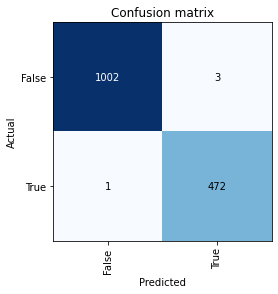

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We can also show the top losses.

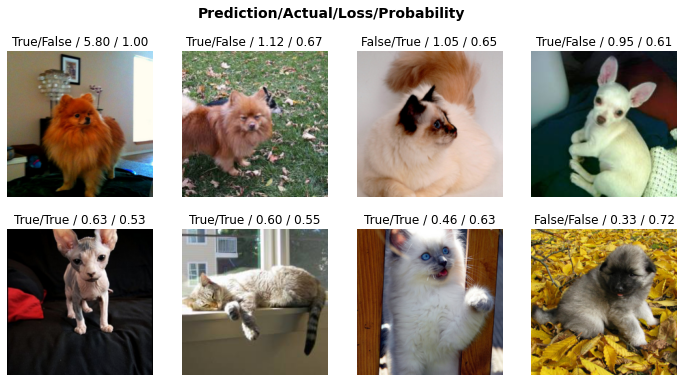

In [12]:
interp.plot_top_losses(8, nrows=2)

Finally, fast.ai offers a GUI to clean our data. It's more preferable to clean our data after training the model because our model can help us find errors in the data more easily. But, it's a bad idea to use for this dataset because we might crash our GPU from running out of RAM.

In [ ]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

Then, we use these functions to deploy our choices from the GUI:

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

After we've cleaned our data, we can retrain the model; or, if we didn't have to clean anything (since our data's from the fast.ai datasets collection), we can skip to exporting.

# Exporting the model

Now that we've created our model, we'll export its `parameters`, `architecture`, and the definition of our `DataLoaders`. 

In [37]:
# First change the path of the DataLoaders
learn.path = Path(os.getcwd())
learn.path

Path('/content')

In [38]:
# Then export the .pkl
learn.export()

In [42]:
# Check that the .pkl exists in the directory
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

To download the exported `.pkl` file, use the download function (specific to Google Colab).

In [41]:
from google.colab import files
files.download('export.pkl') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Using the model

When we want to open a `.pkl` file (the exported file), we use the `load_learner()` function.

In [ ]:
path = Path()
learn_inf = load_learner(path/'export.pkl')

When we use a model to predict something outside of the `training`, `validation`, and `test` set, we call the model an `inference` (hence the additional `_inf` in `learn_inf`).

In [ ]:
learn_inf.predict(img) # note: img is just a placeholder here

We can look at the different vocabulary our model has by looking at the `vocab` variable in the model's `DataLoaders`. But, it's not very relevant for our model because it only gives a `True` or `False` for "is this a cat?".

In [44]:
learn_inf.dls.vocab

[False, True]

# Creating a GUI

We can use *IPython widgets* to create a vertical box to contain our individual widgets.

We'll create:
1. an upload button for the user to upload an image.
2. a widget to display the image.
3. a label to display the results. 
4. a button to classify the image.

In [50]:
# Import
from ipywidgets import *

In [51]:
# Upload button
btn_upload = widgets.FileUpload()

In [52]:
# Display image
out_pl = widgets.Output()

In [53]:
# Predictions
lbl_pred = widgets.Label()

In [54]:
# Classify button
btn_run = widgets.Button(description='Classify')

# Event handler
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {"cat" if pred else "not a cat"}; Probability: {probs[pred_idx]:.6f}'

btn_run.on_click(on_click_classify)

In [ ]:
# Create vertical box
VBox([widgets.Label('Upload your image!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

# Getting the model ready for deployment

We'll need to install the required libraries for Voilà.

In [ ]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

We then use Binder to deploy the app.
1. Enter the URL of the GitHub repository.
2. Enter `/voila/render/name.ipynb` in the "Path to a notebook file (optional)" field, replacing `name` in `name.ipynb` with the name of your Jupyter notebook. 